# **CSAT** **PROJECT**
##Project By - Aayush Kaul


##**Problem Statement :** The primary goal of this project is to develop a deep learning model that accurately predicts the CSAT scores based on the customer interactions and feedback which in turn helps us to monitor and enhance customer satisfaction in real time thereby improving service quality and fostering customer loyalty.

In [1]:
from xgboost import XGBClassifier

In [2]:
!pip install -q scikit-learn
import sklearn

In [3]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [5]:
RANDOM_STATE = 42

# Load Dataset
CSV_NAME = "eCommerce_Customer_support_data.csv"  # <- change if your file has a different name
if not os.path.exists(CSV_NAME):
    raise FileNotFoundError(f"Could not find {CSV_NAME} in current folder.")

In [6]:
# Load Dataset
df = pd.read_csv(CSV_NAME)

print("✅ Data loaded successfully.")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

✅ Data loaded successfully.
Shape: (85907, 20)
Columns: ['Unique id', 'channel_name', 'category', 'Sub-category', 'Customer Remarks', 'Order_id', 'order_date_time', 'Issue_reported at', 'issue_responded', 'Survey_response_Date', 'Customer_City', 'Product_category', 'Item_price', 'connected_handling_time', 'Agent_name', 'Supervisor', 'Manager', 'Tenure Bucket', 'Agent Shift', 'CSAT Score']


In [7]:
# Clean Column Names
df.columns = (
    df.columns
    .str.strip()
    .str.replace(" ", "_")
    .str.replace("-", "_")
)

In [8]:
# 2) Choose target and drop obvious IDs/leaky columns if they exist
TARGET = "CSAT_Score"
drop_if_exist = [
    "Order_id", "Unique_id", "Customer_Remarks_html",  # obvious IDs/noise
]

In [9]:
for c in drop_if_exist:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Columns: {list(df.columns)}")

In [10]:
# Handle Missing Values
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))
print("✅ Missing values handled.")

✅ Missing values handled.


In [11]:
# 3) Feature engineering (dates)
# -----------------------------
# We’ll engineer: order_hour, order_dow, order_month, response_lag_minutes, survey_lag_days
# and then drop original timestamp columns (they're hard to use directly)
def _parse_datetime(s):
    # be defensive: coerce and handle mixed formats
    return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)

date_cols = []
if "order_date_time" in df.columns:
    df["order_date_time"] = _parse_datetime(df["order_date_time"])
    date_cols.append("order_date_time")
if "Issue_reported_at" in df.columns:
    df["Issue_reported_at"] = _parse_datetime(df["Issue_reported_at"])
    date_cols.append("Issue_reported_at")
if "Survey_response_Date" in df.columns:
    df["Survey_response_Date"] = _parse_datetime(df["Survey_response_Date"])
    date_cols.append("Survey_response_Date")

# new features
if "order_date_time" in df.columns:
    df["order_hour"]  = df["order_date_time"].dt.hour
    df["order_dow"]   = df["order_date_time"].dt.dayofweek
    df["order_month"] = df["order_date_time"].dt.month

if {"order_date_time","Issue_reported_at"}.issubset(df.columns):
    df["response_lag_minutes"] = (df["Issue_reported_at"] - df["order_date_time"]).dt.total_seconds() / 60.0

if {"Survey_response_Date","order_date_time"}.issubset(df.columns):
    df["survey_lag_days"] = (df["Survey_response_Date"] - df["order_date_time"]).dt.days

/tmp/ipython-input-2630241721.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
/tmp/ipython-input-2630241721.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(s, errors="coerce", utc=False, infer_datetime_format=True)
/tmp/ipython-input-2630241721.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-

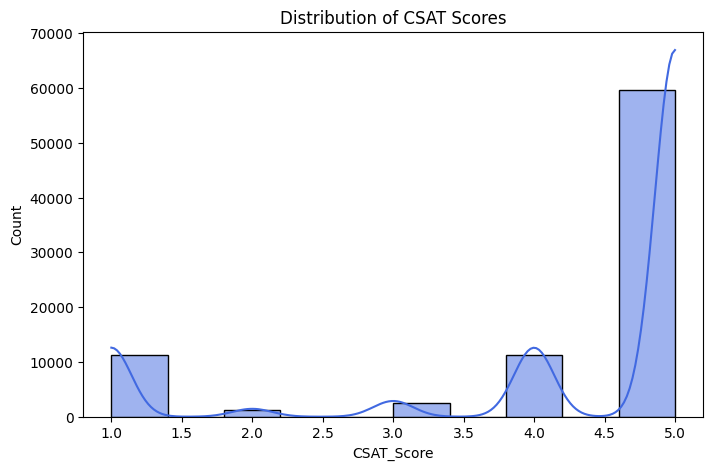

In [12]:
# Exploratory Data Analysis

# CSAT Distribution
plt.figure(figsize=(8,5))
sns.histplot(df["CSAT_Score"], bins=10, kde=True, color="royalblue")
plt.title("Distribution of CSAT Scores")
plt.xlabel("CSAT_Score")
plt.ylabel("Count")
plt.show()

Key Inference from the Chart
Majority of customers give very high satisfaction scores

There is a huge spike at CSAT = 5
→ Most customers are extremely happy with support/service.

Very few extremely negative responses

CSAT = 1 is present but much lower → unhappy customers exist but are a small minority.

Mid-range scores (2, 3, 4) are low

Most customers either:
Had a great experience (5), or
Had a terrible experience (1)

This is a polarized satisfaction pattern.

/tmp/ipython-input-606865197.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="channel_name", y="CSAT_Score", data=df, ci=None, palette="crest")
/tmp/ipython-input-606865197.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="channel_name", y="CSAT_Score", data=df, ci=None, palette="crest")


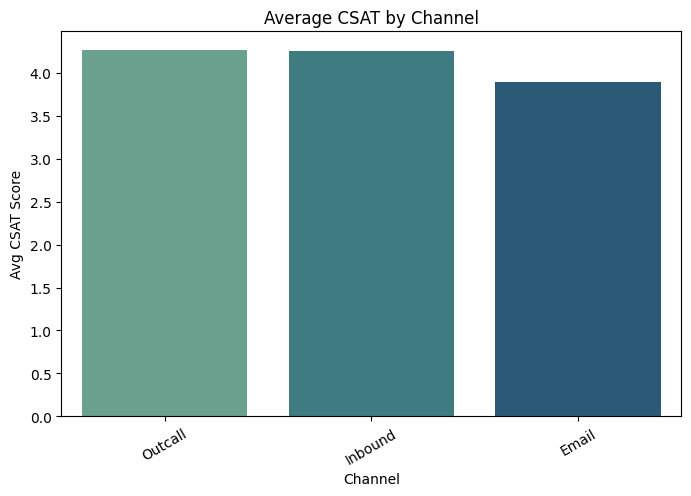

In [13]:
# Average CSAT by Channel
if 'channel_name' in df.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(x="channel_name", y="CSAT_Score", data=df, ci=None, palette="crest")
    plt.title("Average CSAT by Channel")
    plt.xlabel("Channel")
    plt.ylabel("Avg CSAT Score")
    plt.xticks(rotation=30)
    plt.show()

Business Insights

Voice support channels ≈ High Customer Delight

Customers get real-time resolution

More trust due to human interaction

Conversation is clearer vs. text communication

Email channel shows a pain point

Possibly long wait times

Less engaging support

Template replies reduce quality perception

Customers prefer fast & interactive help

Recommended Operational Actions

Issue	Action Plan

Improve turnaround time, personalize responses

Channels differ in experience

Offer training + monitoring on email channel
Opportunity on outbound support	Scale proactive outreach campaigns

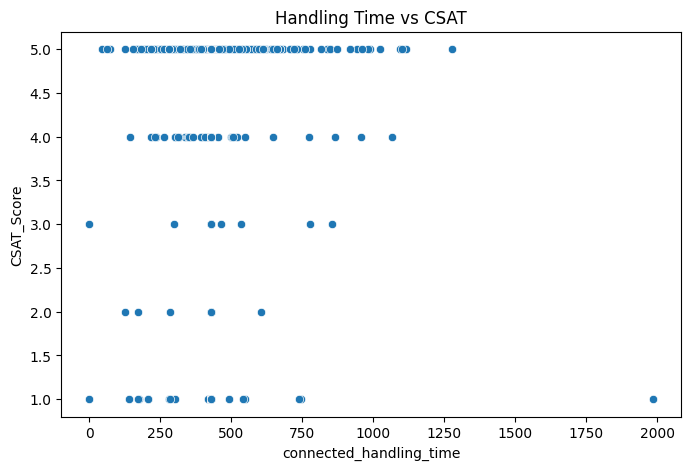

In [14]:
# Handling Time vs CSAT
if 'connected_handling_time' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="connected_handling_time", y="CSAT_Score", data=df)
    plt.title("Handling Time vs CSAT")
    plt.show()

Key Observations

1. High CSAT (5 rating) across a broad range of handling times

   Even customers who waited longer still sometimes gave a 5.

   Suggests agent friendliness & resolution quality matter more than time alone.


2. Low CSAT (1–2 ratings) increase with longer handling times

   As handling time crosses ~500+ seconds:

   More 1 and 2 ratings start appearing

   Customer patience tolerance decreases

   Longer calls = higher dissatisfaction risk.


3. There is no perfect linear relationship

   Handling time alone does not fully determine satisfaction.

   CSAT is influenced by multiple combined factors:

   Issue type

   Agent expertise

   Customer temperament

   Resolution success

Business Insights

Insight	Meaning
Rapid responses generally lead to delight	Faster resolution = better experience

Long calls → frustration	Improve troubleshooting guidance & queue system
Quality of support matters even in long calls	Agents who reassure customers compensate for long waits

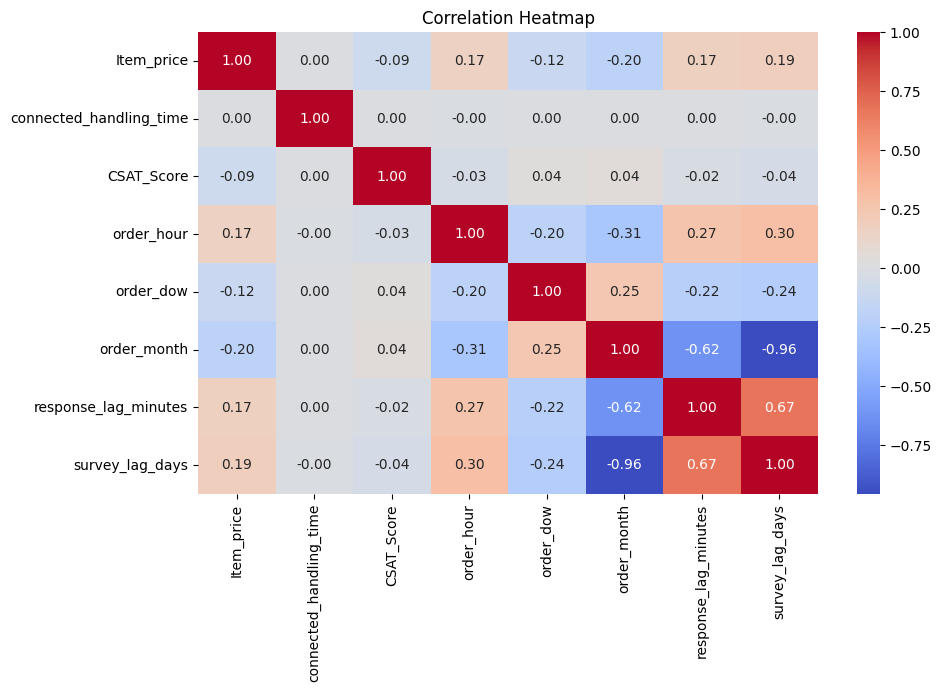

In [15]:
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

This Correlation Heatmap gives very valuable insights into how different numerical features relate to Customer Satisfaction (CSAT) and each other.

Let’s break it down clearly.

Key Findings Related to CSAT Score

Feature	Correlation with CSAT	Interpretation
connected_handling_time	~0.00	Almost no linear impact on CSAT → Quality matters more than duration
item_price	-0.09	Slightly lower CSAT for expensive items → expectations higher
order_hour / order_dow / order_month	very weak	Time-based features do not strongly affect CSAT
response_lag_minutes	-0.02	No strong linear trend but still something to explore in buckets
survey_lag_days	-0.04	Satisfaction doesn’t vary with survey response timing


 Overall: CSAT has weak correlation with numeric factors
 CSAT depends more on categorical / qualitative factors like:

✔ Support channel
✔ Issue type
✔ Agent behavior
✔ Customer sentiment in remarks

Important for slide:

“CSAT is a behavioral measure — emotional aspects influence ratings more than numeric metrics.”

Strong Insights Between Other Variables
Relationship	Interpretation
order_month vs survey_lag_days → -0.96	Customers surveyed later in year respond faster
order_month vs response_lag_minutes → -0.62	Response processes more optimized later in year
response_lag_minutes vs survey_lag_days → +0.67	Longer response delays → slower survey participation

Indicates operational improvement over time

Business Actionable Insights

 Optimize experience for high-value orders
 Focus on qualitative support training instead of just faster handling
 Understand customer frustrations through:

Issue types

Text sentiment

Agent skills

Continue operational improvements that reduced response lag

CSAT has low correlation with numeric metrics like handling time or item price.

This indicates satisfaction is driven by qualitative interaction quality —
such as support channel effectiveness, empathy, and problem resolution.”

In [16]:
# Feature Selection
drop_cols = ['Order_id', 'Unique_id', 'Survey_response_Date', 'Customer_Remarks']
for col in drop_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
print("✅ Dropped irrelevant columns if present.")

✅ Dropped irrelevant columns if present.


In [17]:
# 5) Define feature columns & data splits
# We will *keep* Customer_Remarks as text if present (good signal)
text_col = "Customer_Remarks" if "Customer_Remarks" in df.columns else None

# columns likely to be categorical (common in this dataset)
likely_cats = [
    "channel_name", "issue_responded", "category", "Sub_category",
    "Product_category", "Tenure_Bucket", "Agent_name", "Agent_Shift",
    "Supervisor", "Manager", "Customer_City"
]
likely_cats = [c for c in likely_cats if c in df.columns]

# numeric keepers + engineered ones (present check)
likely_nums = [
    "connected_handling_time", "Item_price",
    "order_hour", "order_dow", "order_month",
    "response_lag_minutes", "survey_lag_days"
]
likely_nums = [c for c in likely_nums if c in df.columns]

In [18]:
# columns we’ll drop from features (timestamps after engineering)
drop_after_eng = [c for c in ["order_date_time", "Issue_reported_at", "Survey_response_Date"] if c in df.columns]

In [19]:
# Build X, y
X = df.drop(columns=[TARGET] + drop_after_eng, errors="ignore").copy()
y = df[TARGET].copy()
y = y.astype(int) - 1 # Subtract 1 to make it 0-indexed

In [20]:
# 6) High vs low cardinality cut
# low-card: one-hot; high-card: frequency encoding (stable & fast)
LOW_CARD_MAX_UNIQUE = 30
low_card_cats = []
high_card_cats = []
for c in likely_cats:
    nunique = X[c].nunique(dropna=True)
    (low_card_cats if nunique <= LOW_CARD_MAX_UNIQUE else high_card_cats).append(c)

print("\nCategoricals split:")
print("  Low-cardinality (one-hot):", low_card_cats)
print("  High-cardinality (freq-enc):", high_card_cats)


Categoricals split:
  Low-cardinality (one-hot): ['channel_name', 'category', 'Product_category', 'Tenure_Bucket', 'Agent_Shift', 'Manager']
  High-cardinality (freq-enc): ['issue_responded', 'Sub_category', 'Agent_name', 'Supervisor', 'Customer_City']


In [21]:
# 7) Custom Frequency Encoder for high-card cat

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    """Frequency-encode each categorical column with its training frequency."""
    def __init__(self, columns=None):
        self.columns = columns
        self.maps_ = {}

    def fit(self, X, y=None):
        X_ = pd.DataFrame(X).copy()
        # Set columns here if not provided in __init__
        if self.columns is None:
            self.columns_ = X_.columns.tolist()
        else:
            self.columns_ = self.columns
        for c in self.columns_:
            if c in X_.columns: # Check if column exists
                freqs = X_.loc[:, c].value_counts(dropna=False) # Use .loc for access
                total = freqs.sum()
                self.maps_[c] = (freqs / total).to_dict()
            else:
                self.maps_[c] = {} # Handle missing column

        return self

    def transform(self, X):
        X_ = pd.DataFrame(X).copy()
        # Use the fitted columns
        if self.columns is None:
             self.columns_ = X_.columns.tolist()
        else:
             self.columns_ = self.columns

        X_.columns = self.columns_
        for c in self.columns_:
            if c in X_.columns: # Check if column exists
                m = self.maps_[c]
                X_.loc[:, c] = X_.loc[:, c].map(m).fillna(0.0).astype(float) # Use .loc for access
            else:
                X_.loc[:, c] = 0.0 # Assign a default value if column is missing
        return X_.values  # numeric array

    # Add get_params and set_params for scikit-learn compatibility
    def get_params(self, deep=True):
        return {"columns": self.columns}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [22]:
# 8) Build preprocessing blocks

numeric_features = likely_nums
text_features = [text_col] if text_col else []
onehot_features = low_card_cats
freqenc_features = high_card_cats

In [23]:
# Transformers
numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale",  StandardScaler())
])

onehot_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

freqenc_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("freqenc", FrequencyEncoder(columns=freqenc_features))
])

In [24]:
# TF-IDF for text ↓ with SVD to keep it compact
if text_col:
    text_pipe = Pipeline(steps=[
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ("svd", TruncatedSVD(n_components=100, random_state=RANDOM_STATE))
    ])

In [25]:
# Column transformer
transformers = []
if numeric_features:
    transformers.append(("num", numeric_pipe, numeric_features))
if onehot_features:
    transformers.append(("onehot", onehot_pipe, onehot_features))
if freqenc_features:
    transformers.append(("freqenc", freqenc_pipe, freqenc_features))
if text_col:
    transformers.append(("text", text_pipe, text_col))

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder="drop",
    verbose_feature_names_out=False
)

In [26]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (68725, 18), Test shape: (17182, 18)


In [27]:
# 10) XGBoost (regularized)

xgb_model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=1.0,
    gamma=0.5,
    random_state=42,
    n_jobs=0
)

In [28]:
# Pipeline
pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])

In [29]:
# 11) Fit
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['connected_handling_time',
                                                   'Item_price', 'order_hour',
                                                   'order_dow', 'order_month',
                                                   'response_lag_minutes',
                                                   'survey_lag_days']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_fre...
                               feature_types=None, feature_weights=None,
                               gamma=0.5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=0, num_class=5, ...))])

In [30]:
# 12) Evaluate
y_pred = pipe.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

joblib.dump(pipe, "model.pkl")
print("✅ Classification model saved as model.pkl")

✅ Accuracy: 0.6946222791293214

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.02      0.04      2241
           1       0.00      0.00      0.00       227
           2       0.00      0.00      0.00       503
           3       0.00      0.00      0.00      2277
           4       0.70      1.00      0.82     11934

    accuracy                           0.69     17182
   macro avg       0.22      0.20      0.17     17182
weighted avg       0.54      0.69      0.57     17182

✅ Classification model saved as model.pkl


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
# 13) Save model + schema
joblib.dump(pipe, "model.pkl")
print("✅ Saved: model.pkl")

✅ Saved: model.pkl


In [32]:
from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Save input schema (the raw field names your Flask should accept)
schema = {
    "expected_fields": list(X.columns),
    "target": TARGET,
    "generated_features_info": {
        "engineered": ["order_hour", "order_dow", "order_month", "response_lag_minutes", "survey_lag_days"],
        "dropped_timestamps": drop_after_eng,
        "one_hot": onehot_features,
        "freq_encoded": freqenc_features,
        "numeric": numeric_features,
        "text": text_col if text_col else None
    }
}
with open("input_schema.json", "w", encoding="utf-8") as f:
    json.dump(schema, f, indent=2)
print("✅ Saved: input_schema.json (use this to craft your /predict payload)")

print("\n🎉 Done. You can now deploy model.pkl with Flask.")

✅ Saved: input_schema.json (use this to craft your /predict payload)

🎉 Done. You can now deploy model.pkl with Flask.
